In [1]:
import warnings
warnings.filterwarnings("ignore")
import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")

In [63]:
security_df_selected_columns = security_df[['Vols_normalized',
       'Cambriolages à domicile ou violaiton de domicile_normalized',
       'Crimes ou délits sexuelles_normalized',
       'Infractions liées aux stupéfiants_normalized',
       'Dégradations ou destructions de biens volontaires_normalized',
       'Violences_normalized', 'Falsifications et contrefaçons_normalized',
       'Délits Économiques et Financiers_normalized',
       "Irégularités de Main-d'oeuvre_normalized", "code_dep"]]

In [64]:
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()

In [65]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

colonnes_pca = ['Vols_normalized',
       'Cambriolages à domicile ou violaiton de domicile_normalized',
       'Crimes ou délits sexuelles_normalized',
       'Infractions liées aux stupéfiants_normalized',
       'Dégradations ou destructions de biens volontaires_normalized',
       'Violences_normalized', 'Falsifications et contrefaçons_normalized',
       'Délits Économiques et Financiers_normalized',
       "Irégularités de Main-d'oeuvre_normalized"]


donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)

# Application de la PCA
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)

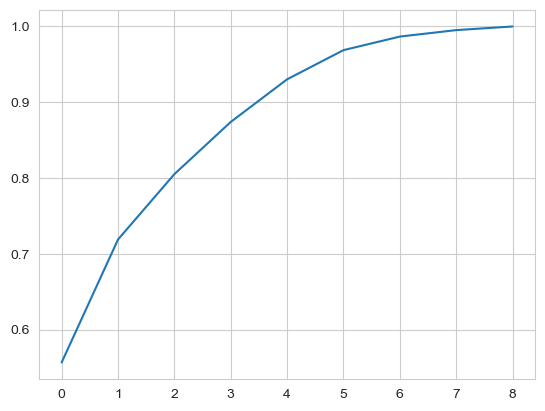

In [66]:
plt.plot(np.cumsum(resultats_pca.explained_variance_ratio_))

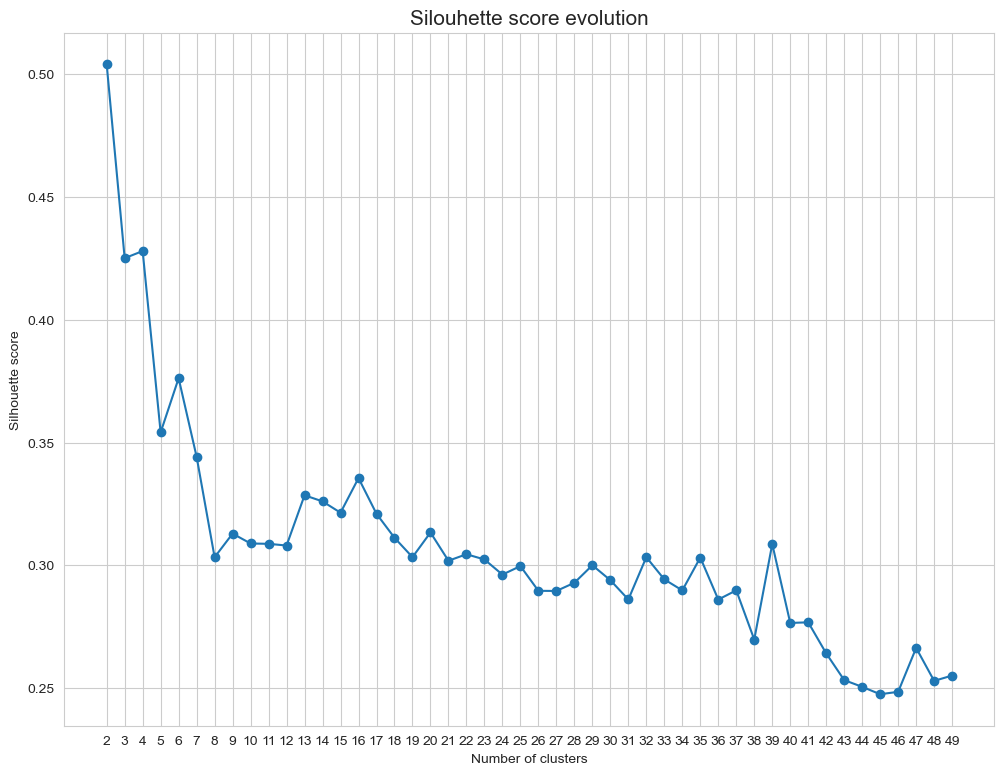

In [69]:
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']

best_nb_cluster = tools.best_nb_cluster(
        resultats_pca_df,
        ['PCA1', 'PCA2', 'PCA3'],
        2,
        50,
        True,
        "Silouhette score evolution"
)

In [ ]:
tools.clustering(resultat_agregation,
                 ['crimes_combined'],
                 2)